# Gestructureerde data: Complexere architecturen

In de voorgaande onderdelen heb je reeds gemerkt dat het verwerken van de input in het geval van gestructureerde data kan leiden tot een complexere netwerkarchitectuur.
In deze notebook gaan we dit in meer detail bestuderen en ook kijken naar de mogelijkheden aan de output-kant van het netwerk.

## Multi-modal modellen (meerdere inputs combineren voor 1 output)

Een multi-modal neuraal netwerk is een netwerk dat leert van meerdere soorten data (modaliteiten) tegelijk. Modaliteiten kunnen bijvoorbeeld zijn:

* Gestructureerde data (sensorwaarden, tabellen, tijdreeksen)
* Beelden (RGB-foto's, video frames)
* Tekst (reviews, captions, transcripties)
* Audio (spraak, muziek)

Het doel is om de informatie uit verschillende bronnen te combineren zodat het model betere prestaties kan leveren dan wanneer je slechts één modaliteit gebruikt.

Elke modaliteit heeft vaak een gespecialiseerde encoder:
| Modaliteit    | Veelgebruikte encoders                               |
| ------------- | ---------------------------------------------------- |
| Gestructureerde | Fully connected layers, tabular transformers         |
| Beeld         | CNN (ResNet, EfficientNet), ViT (Vision Transformer) |
| Tekst         | RNN, LSTM, GRU, Transformers (BERT, GPT)             |
| Audio         | 1D-CNN, spectrogram + 2D-CNN, Wav2Vec                |

Er zijn verschillende manieren om features van de verscheidene modaliteiten te combineren:

* Early fusion: De ruwe data wordt gecombineerd vóór het netwerk (vaak lastig bij verschillende soorten data).
* Intermediate fusion: Features van verschillende subnetwerken worden gecombineerd in een middenlaag (meest gebruikelijk).
* Late fusion: Elke modaliteit geeft een voorspelling en die worden gecombineerd (bijv. gemiddelde, gewogen gemiddelde, of meta-classifier). Dit lijkt op de klassieke ensemble technieken die we vorig jaar gezien hebben.

Met pytorch ziet dit eruit als volgt:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Encoder voor modaliteit 1 ---
class Modality1Encoder(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, out_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.fc(x)

# --- Encoder voor modaliteit 2 ---
class Modality2Encoder(nn.Module):
    def __init__(self, input_dim=15, hidden_dim=32, out_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.fc(x)

# --- Multi-modal model met feedforward subnetwerken ---
class MultiModalFFNN(nn.Module):
    def __init__(self, input_dim1, input_dim2, num_classes):
        super().__init__()
        self.mod1_encoder = Modality1Encoder(input_dim=input_dim1, out_dim=128)
        self.mod2_encoder = Modality2Encoder(input_dim=input_dim2, out_dim=128)
        self.classifier = nn.Linear(128*2, num_classes)
    
    def forward(self, x1, x2):
        feat1 = self.mod1_encoder(x1)
        feat2 = self.mod2_encoder(x2)
        combined = torch.cat([feat1, feat2], dim=1)  # feature fusion
        out = self.classifier(combined)
        return out

# --- Voorbeeld input ---
batch_size = 4
x1 = torch.randn(batch_size, 20)  # modaliteit 1
x2 = torch.randn(batch_size, 15)  # modaliteit 2

model = MultiModalFFNN(input_dim1=20, input_dim2=15, num_classes=5)
output = model(x1, x2)
print(output.shape)  # torch.Size([4, 5])


torch.Size([4, 5])


Met de functial API van Keras ziet dit er dan uit als volgt

In [2]:
import keras_core as keras
from keras_core import layers, models, Input

# --- Encoder voor modaliteit 1 ---
def Modality1Encoder(input_dim=20, hidden_dim=64, out_dim=128):
    inputs = Input(shape=(input_dim,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dense(out_dim, activation='relu')(x)
    return models.Model(inputs, x, name="Modality1Encoder")

# --- Encoder voor modaliteit 2 ---
def Modality2Encoder(input_dim=15, hidden_dim=32, out_dim=128):
    inputs = Input(shape=(input_dim,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dense(out_dim, activation='relu')(x)
    return models.Model(inputs, x, name="Modality2Encoder")

# --- Multi-modal model ---
def MultiModalFFNN(input_dim1=20, input_dim2=15, num_classes=5):
    # Inputs
    input1 = Input(shape=(input_dim1,), name="modality1_input")
    input2 = Input(shape=(input_dim2,), name="modality2_input")
    
    # Subnetwerken
    mod1_feat = Modality1Encoder(input_dim1)(input1)
    mod2_feat = Modality2Encoder(input_dim2)(input2)
    
    # Feature fusion
    combined = layers.Concatenate()([mod1_feat, mod2_feat])
    
    # Classifier
    output = layers.Dense(num_classes, activation='softmax')(combined)
    
    model = models.Model(inputs=[input1, input2], outputs=output)
    return model

# --- Model initialiseren ---
model = MultiModalFFNN(input_dim1=20, input_dim2=15, num_classes=5)
model.summary()

# --- Voorbeeld input ---
import numpy as np
x1 = np.random.randn(4, 20)  # batch size 4
x2 = np.random.randn(4, 15)
y = np.random.randint(0, 5, size=(4,))

# --- Model compileren en trainen ---
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit([x1, x2], y, epochs=3)


Using PyTorch backend.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ modality1_input     │ (None, 20)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ modality2_input     │ (None, 15)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Modality1Encoder    │ (None, 128)       │   9,664 │ modality1_input[0][… │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Modality2Encoder    │ (None, 128)       │   4,736 │ modality2_input[0][… │
│ (Functional)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 256)       │       0 │ Modality1Encoder[0]… │
│ (Concatenate)       │                   │         │ Modality2Encoder[0]… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │   1,285 │ concatenate[0][0]    │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 15,685 (61.27 KB)

 Trainable params: 15,685 (61.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5000 - loss: 1.3973
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5000 - loss: 1.2213
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7500 - loss: 1.0625


## Multi-task/output/head model

Een multi-task neuraal netwerk is een netwerk dat meerdere gerelateerde taken tegelijk leert. In plaats van voor elke taak een afzonderlijk netwerk te trainen, wordt één netwerk gedeeld over taken. Dit kan leiden tot betere generalisatie, omdat het netwerk gedeelde representaties leert die nuttig zijn voor meerdere taken.

Voorbeelden van multi-task learning:

* Gezichtsherkenning: voorspellen van leeftijd, geslacht en emotie van hetzelfde gezicht.
* Tabulaire data: voorspellen van zowel een continu resultaat (regressie) als een categorie (classificatie) uit dezelfde features.
* Gezondheidszorg: voorspellen van meerdere symptomen of uitkomsten uit patiëntgegevens.

Een multi-task model heeft vaak gedeelde lagen (shared layers) die features leren die nuttig zijn voor alle taken, en taakspecifieke lagen (task-specific layers) die de uiteindelijke voorspelling voor elke taak maken. Dit resulteert inde volgende architectuur.

* De eerste lagen zijn gedeeld voor alle taken.
* Daarna heeft elke taak een eigen output layer.

Daarnaast moet er voldoende aandacht besteed worden aan de loss-functie van dit netwerk.
Omdat er nu meerdere taken zijn, zijn er ook meerdere fouten (1 per taak).
Om het netwerk correct te trainen moet je de loss-functies combineren tot een samengestelde lossfunctie (vermenigvuldig elke loss-functie met een factor die je kiest en tel ze op).
Het gewicht van de loss-functie is echter belangrijk voor goed learning en om een goede waarde te vinden kan het nodig zijn om met verschillende parameters te experimenteren.

Hieronder staat een eenvoudig feedforward multi-task model in PyTorch dat één regressie- en één classificatietaak tegelijk uitvoert.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Multi-task feedforward netwerk ---
class MultiTaskFFNN(nn.Module):
    def __init__(self, input_dim, shared_dim=64, task1_dim=32, task2_dim=32, num_classes=3):
        super().__init__()
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, shared_dim),
            nn.ReLU(),
            nn.Linear(shared_dim, shared_dim),
            nn.ReLU()
        )
        
        # Taakspecifieke layers
        self.task1 = nn.Sequential(  # regressie
            nn.Linear(shared_dim, task1_dim),
            nn.ReLU(),
            nn.Linear(task1_dim, 1)  # output 1 waarde
        )
        
        self.task2 = nn.Sequential(  # classificatie
            nn.Linear(shared_dim, task2_dim),
            nn.ReLU(),
            nn.Linear(task2_dim, num_classes)  # logits
        )
    
    def forward(self, x):
        shared_feat = self.shared(x)
        out1 = self.task1(shared_feat)
        out2 = self.task2(shared_feat)
        return out1, out2

# --- Voorbeeld input ---
batch_size = 4
input_dim = 10
x = torch.randn(batch_size, input_dim)

model = MultiTaskFFNN(input_dim=input_dim, num_classes=3)
out1, out2 = model(x)
print("Regressie output:", out1.shape)  # torch.Size([4,1])
print("Classificatie output:", out2.shape)  # torch.Size([4,3])

# --- Voorbeeld training loop ---
y_reg = torch.randn(batch_size,1)
y_class = torch.randint(0,3,(batch_size,))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn_reg = nn.MSELoss()
loss_fn_class = nn.CrossEntropyLoss()

for epoch in range(5):
    optimizer.zero_grad()
    out1, out2 = model(x)
    loss1 = loss_fn_reg(out1, y_reg)
    loss2 = loss_fn_class(out2, y_class)
    loss = 0.4 * loss1 + 0.6 * loss2  # eenvoudige gewogen som
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model_pytorch = model

Regressie output: torch.Size([4, 1])
Classificatie output: torch.Size([4, 3])
Epoch 0, Loss: 1.5045
Epoch 1, Loss: 1.4678
Epoch 2, Loss: 1.4329
Epoch 3, Loss: 1.4000
Epoch 4, Loss: 1.3674


Met Keras ziet dit eruit als volgt

In [4]:
import keras_core as keras
from keras_core import layers, models, Input

# --- Multi-task feedforward netwerk ---
def MultiTaskFFNN(input_dim=10, shared_dim=64, task1_dim=32, task2_dim=32, num_classes=3):
    # Input layer
    inputs = Input(shape=(input_dim,), name="input_layer")
    
    # Shared layers
    x = layers.Dense(shared_dim, activation='relu')(inputs)
    x = layers.Dense(shared_dim, activation='relu')(x)
    
    # Taakspecifieke layers
    # Task 1: regressie
    t1 = layers.Dense(task1_dim, activation='relu')(x)
    t1_out = layers.Dense(1, name="regression_output")(t1)
    
    # Task 2: classificatie
    t2 = layers.Dense(task2_dim, activation='relu')(x)
    t2_out = layers.Dense(num_classes, activation='softmax', name="classification_output")(t2)
    
    # Model
    model = models.Model(inputs=inputs, outputs=[t1_out, t2_out])
    return model

# --- Model initialiseren ---
input_dim = 10
num_classes = 3
model = MultiTaskFFNN(input_dim=input_dim, num_classes=num_classes)
model.summary()

# --- Voorbeeld data ---
import numpy as np
batch_size = 4
x = np.random.randn(batch_size, input_dim)
y_reg = np.random.randn(batch_size, 1)
y_class = np.random.randint(0, num_classes, size=(batch_size,))

# --- Model compileren ---
model.compile(
    optimizer='adam',
    loss={
        "regression_output": "mse",
        "classification_output": "sparse_categorical_crossentropy"
    },
    metrics={
        "regression_output": ["mae"],
        "classification_output": ["accuracy"]
    }
)

# --- Model trainen ---
model.fit(x, {"regression_output": y_reg, "classification_output": y_class}, epochs=5)

model_keras = model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     704 │ input_layer[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │   4,160 │ dense_5[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │   2,080 │ dense_6[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │   2,080 │ dense_6[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ regression_output   │ (None, 1)         │      33 │ dense_7[0][0]        │
│ (Dense)             │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ classification_out… │ (None, 3)         │      99 │ dense_8[0][0]        │
│ (Dense)             │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 9,156 (35.77 KB)

 Trainable params: 9,156 (35.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - classification_output_accuracy: 0.2500 - loss: 3.5111 - regression_output_mae: 1.2092
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_output_accuracy: 0.2500 - loss: 3.3936 - regression_output_mae: 1.1780
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_output_accuracy: 0.2500 - loss: 3.2817 - regression_output_mae: 1.1484
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_output_accuracy: 0.5000 - loss: 3.1758 - regression_output_mae: 1.1203
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_output_accuracy: 0.5000 - loss: 3.0794 - regression_output_mae: 1.0955


## Visualisatie van model architecturen

Er zijn heel wat verschillende manieren om de netwerkarchitectuur te visualiseren om goed te begrijpen wat er gebeurd.
Hieronder staan er een aantal voorbeelden voor

**PYTORCH**

In [5]:
# print model
print(model_pytorch)

MultiTaskFFNN(
  (shared): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (task1): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (task2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [6]:
# print summary
from torchinfo import summary

summary(model_pytorch, input_size=(4,10))

Layer (type:depth-idx)                   Output Shape              Param #
MultiTaskFFNN                            [4, 1]                    --
├─Sequential: 1-1                        [4, 64]                   --
│    └─Linear: 2-1                       [4, 64]                   704
│    └─ReLU: 2-2                         [4, 64]                   --
│    └─Linear: 2-3                       [4, 64]                   4,160
│    └─ReLU: 2-4                         [4, 64]                   --
├─Sequential: 1-2                        [4, 1]                    --
│    └─Linear: 2-5                       [4, 32]                   2,080
│    └─ReLU: 2-6                         [4, 32]                   --
│    └─Linear: 2-7                       [4, 1]                    33
├─Sequential: 1-3                        [4, 3]                    --
│    └─Linear: 2-8                       [4, 32]                   2,080
│    └─ReLU: 2-9                         [4, 32]                   --
│    

In [7]:
# print each layer
for name, layer in model.named_modules():
    print(name, layer)

 <Functional name=functional_3, built=True>
torch_params ParameterList(
    (0): Parameter containing: [torch.float32 of size 10x64 (cuda:0)]
    (1): Parameter containing: [torch.float32 of size 64 (cuda:0)]
    (2): Parameter containing: [torch.float32 of size 64x64 (cuda:0)]
    (3): Parameter containing: [torch.float32 of size 64 (cuda:0)]
    (4): Parameter containing: [torch.float32 of size 64x32 (cuda:0)]
    (5): Parameter containing: [torch.float32 of size 32 (cuda:0)]
    (6): Parameter containing: [torch.float32 of size 64x32 (cuda:0)]
    (7): Parameter containing: [torch.float32 of size 32 (cuda:0)]
    (8): Parameter containing: [torch.float32 of size 32x1 (cuda:0)]
    (9): Parameter containing: [torch.float32 of size 1 (cuda:0)]
    (10): Parameter containing: [torch.float32 of size 32x3 (cuda:0)]
    (11): Parameter containing: [torch.float32 of size 3 (cuda:0)]
)


In [8]:
# make figure of the architecture
from torchviz import make_dot

x = torch.randn(1, 10, requires_grad=True)
x = x.to("cuda")
y1, y2 = model_pytorch(x)

combined = torch.cat([y1, y2.float()], dim=1)  # y2 naar float bij classificatie logits
dot = make_dot(combined, params=dict(model.named_parameters()))
dot.render("model_graph_combined", format="png") # kan verduidelijkt worden door:  with torch.autograd.profiler.record_function("shared") in de forward functie om stappen te combineren

'model_graph_combined.png'

**KERAS**

In [13]:
model_keras.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     704 │ input_layer[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │   4,160 │ dense_5[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │   2,080 │ dense_6[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │   2,080 │ dense_6[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ regression_output   │ (None, 1)         │      33 │ dense_7[0][0]        │
│ (Dense)             │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ classification_out… │ (None, 3)         │      99 │ dense_8[0][0]        │
│ (Dense)             │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 27,470 (107.30 KB)

 Trainable params: 9,156 (35.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,314 (71.54 KB)

In [14]:
for layer in model_keras.layers:
    print(layer)

<InputLayer name=input_layer, built=True>
<Dense name=dense_5, built=True>
<Dense name=dense_6, built=True>
<Dense name=dense_7, built=True>
<Dense name=dense_8, built=True>
<Dense name=regression_output, built=True>
<Dense name=classification_output, built=True>


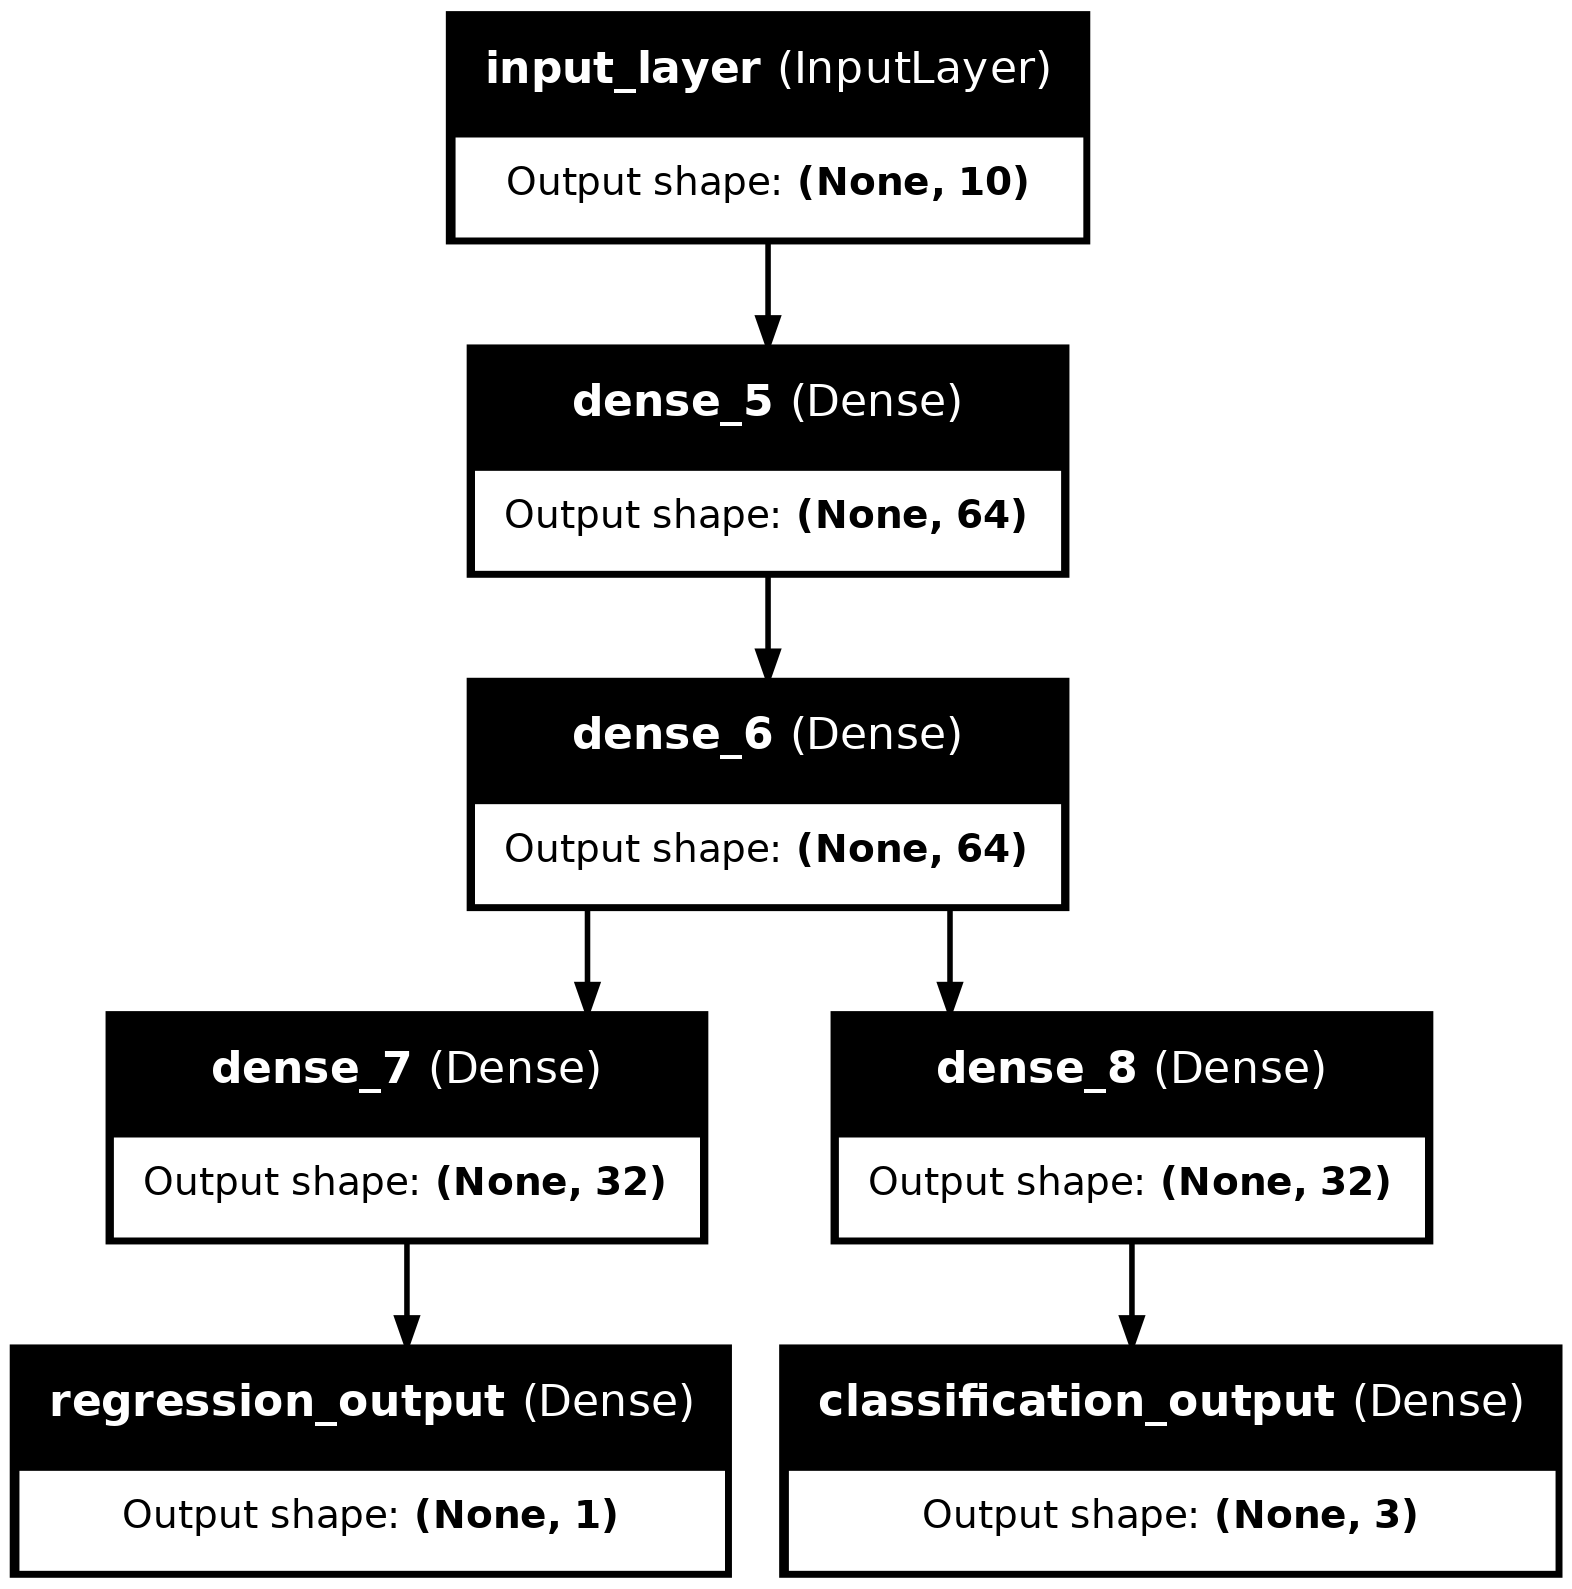

In [15]:
from keras_core.utils import plot_model

plot_model(model_keras, to_file="model.png", show_shapes=True, show_layer_names=True)

## Oefening - multitask

Ga aan de slag met [de wine-quality dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).
Je kan de dataset downloaden met kagglehub of manueel.

De op te lossen taken met deze dataset zijn:

* Taak 1: Voorspel de kwaliteit (quality) als integer score 0–10 → classificatie of regressie (kan als beiden)
* Taak 2: Voorspel of de wijn goed is of slecht (bijvoorbeeld quality >= 6) → binary classification

Voer hieronder de volgende stappen uit en train zowel een pytorch model als een keras model:

* Data inspecteren: bekijk statistieken, histogram van kwaliteit en good/bad labels.
* Preprocessing: normalisatie van features.
* Split train/test.
* Model bouwen:
  * Shared layers
  * Task-specific heads (regression + binary)
* Loss functies instellen (MSE voor regressie, BCE voor classificatie)
* Train model
* Evalueer prestaties op beide taken (MAE voor regressie, accuracy voor binary)

In [ ]:
# data voorbereiden
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import kagglehub

# Load dataset
path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")
df = pd.read_csv(f"{path}/winequality-red.csv", sep=",")

display(df.head())

# Maak een binary target voor task 2
df['good_quality'] = (df['quality'] >= 6).astype(int)

# Features en targets
features = df.drop(columns=['quality', 'good_quality'])
target_quality = df['quality'].values  # Task 1: regressie or classification
target_good = df['good_quality'].values  # Task 2: binary

# Split train/test
X_train, X_test, y_quality_train, y_quality_test, y_good_train, y_good_test = train_test_split(
    features.values.astype("float32"),
    target_quality.astype("float32"),
    target_good.astype("float32"),
    test_size=0.2,
    random_state=42
)


In [ ]:
# dataloaders
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class WineDataset(Dataset):
    def __init__(self, X, y1, y2):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y1 = torch.tensor(y1, dtype=torch.float32).unsqueeze(1)
        self.y2 = torch.tensor(y2, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y1[idx], self.y2[idx]

train_dataset = WineDataset(X_train, y_quality_train, y_good_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = WineDataset(X_test, y_quality_test, y_good_test)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
class MultiTaskWineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.regression_head = nn.Linear(32, 1)
        self.binary_head = nn.Linear(32, 1)
    def forward(self, x):
        x = self.shared(x)
        return self.regression_head(x), torch.sigmoid(self.binary_head(x))


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultiTaskWineNN(input_dim=X_train.shape[1]).to(device)

criterion_reg = nn.MSELoss()
criterion_bin = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 5. Training loop
# -----------------------------
epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_reg, y_bin in train_loader:
        X_batch = X_batch.to(device)
        y_reg = y_reg.to(device)
        y_bin = y_bin.to(device)
        
        optimizer.zero_grad()
        pred_reg, pred_bin = model(X_batch)
        
        loss_reg = criterion_reg(pred_reg, y_reg)
        loss_bin = criterion_bin(pred_bin, y_bin)
        loss = loss_reg + loss_bin
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct_bin = 0
        total_bin = 0
        for X_batch, y_reg, y_bin in test_loader:
            X_batch = X_batch.to(device)
            y_reg = y_reg.to(device)
            y_bin = y_bin.to(device)
            
            pred_reg, pred_bin = model(X_batch)
            loss_reg = criterion_reg(pred_reg, y_reg)
            loss_bin = criterion_bin(pred_bin, y_bin)
            loss = loss_reg + loss_bin
            test_loss += loss.item() * X_batch.size(0)
            
            predicted = (pred_bin > 0.5).float()
            correct_bin += (predicted == y_bin).sum().item()
            total_bin += y_bin.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_acc = correct_bin / total_bin
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f} - Test Loss: {test_loss:.4f} - Test Binary Acc: {test_acc:.4f}")

**Met Keras**

In [ ]:
# bouw en train model with keras